# M2608.001300 기계학습 기초 및 전기정보 응용<br> Assignment #4 Part 2: Recurrent Neural Networks (RNNs)

Copyright (C) Data Science & AI Laboratory, Seoul National University. This material is for educational uses only. Some contents are based on the material provided by other paper/book authors and may be copyrighted by them. Written by Bong-Gyun Kang, May 2023.

**For understanding of this work, please carefully look at given PPT file.**

Now, you're going to leave behind your implementations and instead migrate to one of popular deep learning frameworks, **PyTorch**. <br>

In this notebook, you will learn how to train a Recurrent Neural Network (RNN) for sequential modeling. Specifically, you will build a character-level RNN to generate names from different languages. <br> 
You need to follow the instructions to **complete 6 TODO sections and explain them if needed.**

You will see:
- how to implement a character-level RNN in PyTorch;
- train the network; and
- sampling sequences from the network.


**Note**: certain details are missing or ambiguous on purpose, in order to test your knowledge on the related materials. However, if you really feel that something essential is missing and cannot proceed to the next step, then contact the teaching staff with clear description of your problem.

<font color=red>**DO NOT clear the final outputs**</font> so that TAs can grade both your code and results. 


### Some helpful tutorials and references for assignment #4:
- [1] Pytorch official documentation. [[link]](https://pytorch.org/docs/stable/index.html)
- [2] Stanford CS231n lectures. [[link]](http://cs231n.stanford.edu/)
- [3] https://ratsgo.github.io/machine%20learning/2017/03/18/HMMs/
- [4] https://ratsgo.github.io/natural%20language%20processing/2017/03/09/rnnlstm/

In [1]:
%matplotlib inline

Preparing the Data
==================

Note:
   Extract the ``rnn_data.zip`` to the current directory.

The dataset has a bunch of plain text files ``data/names/[Language].txt`` with a
name per line. We split lines into an array, convert Unicode to ASCII,
and end up with a dictionary ``{language: [names ...]}``.




Execute the following 2 cells if you are using Google Colab, otherwise just skip. Rename the statement after `cd` with your current directory (e.g. `cd /content/drive/your/current/directory/`). Refer to Assignment1's data loading sceme if you have troubles.

In [ ]:
# Execute this and below cell if you are using Google Colab, otherwise just skip.
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
cd /content/drive/MyDrive/

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

def findFiles(path): return glob.glob(path)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

# Build the category_lines dictionary, a list of lines per category
category_lines = {}
all_categories = []
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded rnn_data.zip '
        'from eTL and extract it to the current directory.')

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

# categories: 18 ['Chinese', 'Greek', 'French', 'Italian', 'Russian', 'Portuguese', 'Polish', 'Japanese', 'Korean', 'Czech', 'Spanish', 'Irish', 'Vietnamese', 'Arabic', 'German', 'English', 'Scottish', 'Dutch']
O'Neal


Problem 1. Creating the Network
====================

**TODO 1**: Instead of using ``torch.nn.RNN``, build your own RNN network.

RNN architecture in order:
- ``i2h`` : a linear layer for the hidden
- ``i2o`` : a linear layer for the output
- ``o2o`` : a linear layer after combining hidden and output
- ``dropout`` : randomly zeros parts of its
input <https://arxiv.org/abs/1207.0580>`__ with a given probability
(here 0.1) and is usually used to fuzz inputs to prevent overfitting.
- ``softmax`` : LogSoftmax for the final output

Category tensor is a one-hot vector just like the letter input and it is concatenated with the input and hidden. Output is interpreted as the probability of the next letter. When sampling, the most likely output letter is used as the next input letter.





In [2]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        ##############################################################################
        #                          IMPLEMENT YOUR CODE                               #
        ##############################################################################
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.softmax = nn.LogSoftmax()

        ##############################################################################
        #                          END OF YOUR CODE                                  #
        ##############################################################################

    def forward(self, category, input, hidden):
        ##############################################################################
        #                          IMPLEMENT YOUR CODE                               #
        ##############################################################################
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_concat = torch.cat((hidden, output), 1)
        output = self.o2o(output_concat)
        
        ##############################################################################
        #                          END OF YOUR CODE                                  #
        ##############################################################################
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

Training
=========
Preparing for Training
----------------------

First of all, helper functions to get random pairs of (category, line):




In [3]:
import random

# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

For each timestep (that is, for each letter in a training word) the
inputs of the network will be
``(category, current letter, hidden state)`` and the outputs will be
``(next letter, next hidden state)``. So for each training set, we'll
need the category, a set of input letters, and a set of output/target
letters.

Since we are predicting the next letter from the current letter for each
timestep, the letter pairs are groups of consecutive letters from the
line - e.g. for ``"ABCD<EOS>"`` we would create ("A", "B"), ("B", "C"),
("C", "D"), ("D", "EOS").

The category tensor is a `one-hot
tensor`__ of size
``<1 x n_categories>``. When training we feed it to the network at every
timestep - this is a design choice, it could have been included as part
of initial hidden state or some other strategy.




In [4]:
# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

For convenience during training we'll make a ``randomTrainingExample``
function that fetches a random (category, line) pair and turns them into
the required (category, input, target) tensors.




In [5]:
# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

In [6]:
category, line = randomTrainingPair()
category_tensor = categoryTensor(category)
input_line_tensor = inputTensor(line)
target_line_tensor = targetTensor(line)

In [7]:
category, line

('Dutch', 'Maes')

Problem 2. Training the Network
--------------------

In contrast to classification, where only the last output is used, we
are making a prediction at every step, so we are calculating loss at
every step.

The magic of autograd allows you to simply sum these losses at each step
and call backward at the end.

**TODO 2**: Define a loss function, learning rate and hidden size for RNN training.




In [25]:
# Define a loss function, learning rate, hidden size
##############################################################################
#                          IMPLEMENT YOUR CODE                               #
##############################################################################

learning_rate = 0.0005
n_hidden = 128
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

rnn = RNN(n_letters, n_hidden, n_letters)

##############################################################################
#                          END OF YOUR CODE                                  #
##############################################################################

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)

To keep track of how long training takes I am adding a
``timeSince(timestamp)`` function which returns a human readable string:




In [16]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

Training is business as usual - call train a bunch of times and wait a
few minutes, printing the current time and loss every ``print_every``
examples, and keeping store of an average loss per ``plot_every`` examples
in ``all_losses`` for plotting later.




In [17]:
rnn = RNN(n_letters, n_hidden, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0
torch.save(rnn.state_dict(), 'RNN.pth')

0m 6s (5000 5%) 2.4502
0m 13s (10000 10%) 2.5936
0m 19s (15000 15%) 2.0203
0m 26s (20000 20%) 1.8849
0m 32s (25000 25%) 2.3129
0m 39s (30000 30%) 2.9481
0m 46s (35000 35%) 3.0483
0m 52s (40000 40%) 2.6644
0m 58s (45000 45%) 2.0645
1m 5s (50000 50%) 2.3832
1m 11s (55000 55%) 2.6286
1m 17s (60000 60%) 1.8435
1m 23s (65000 65%) 1.3536
1m 30s (70000 70%) 2.0662
1m 36s (75000 75%) 2.7435
1m 42s (80000 80%) 2.2908
1m 48s (85000 85%) 2.0660
1m 55s (90000 90%) 2.4593
2m 1s (95000 95%) 2.1312
2m 7s (100000 100%) 2.4394


Plotting the Losses
-------------------

Plotting the historical loss from all\_losses shows the network
learning:




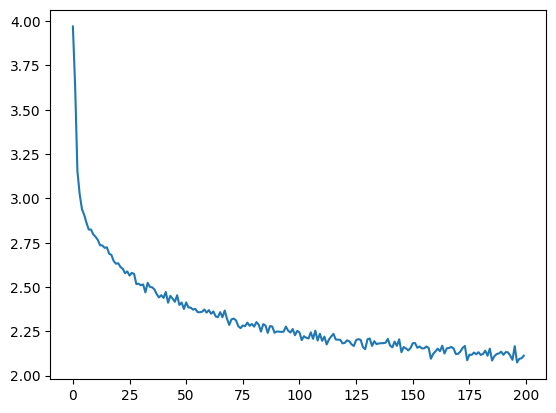

In [18]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

Problem 3. Sampling from the Network
====================

**TODO 3**: To sample we give the network a letter and ask what the next one is,
feed that in as the next letter, and repeat until the EOS token.

-  Create tensors for input category, starting letter, and empty hidden
   state
-  Create a string ``output_name`` with the starting letter
-  Up to a maximum output length,

   -  Feed the current letter to the network
   -  Get the next letter from highest output, and next hidden state
   -  If the letter is EOS, stop here
   -  If a regular letter, add to ``output_name`` and continue

-  Return the final name

.. Note::
   Rather than having to give it a starting letter, another
   strategy would have been to include a "start of string" token in
   training and have the network choose its own starting letter.




In [23]:
max_length = 20

# Sample from a category and starting letter
def sample(category, start_letter='A'):
    ##############################################################################
    #                          IMPLEMENT YOUR CODE                               #
    ##############################################################################
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor(category)  # Convert category to tensor
        input_tensor = inputTensor(start_letter)  # Convert start letter to tensor
        hidden_state = rnn.initHidden()  # Initialize the hidden state

        output_name = start_letter  # Start the output name with the initial letter

        for _ in range(max_length):
            output, hidden_state = rnn(category_tensor, input_tensor[0], hidden_state)  # Forward pass
            top_value, top_index = output.topk(1)  # Get the top value and index
            top_index = top_index.item()  # Convert tensor to scalar

            if top_index == n_letters - 1:  # If the EOS token is reached, stop generation
                break
            else:
                predicted_letter = all_letters[top_index]  # Get the corresponding letter
                output_name += predicted_letter  # Append the letter to the output name

            input_tensor = inputTensor(predicted_letter)  # Update the input tensor for the next iteration
    
    
    ##############################################################################
    #                          END OF YOUR CODE                                  #
    ##############################################################################
        return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

**TODO 4**: Sample 12 different names from 4 languages (i.e. 3 names per language). Use the ``samples`` function defined above.

In [24]:
##############################################################################
#                          IMPLEMENT YOUR CODE                               #
##############################################################################
samples('Russian', 'ABC')
samples('German', 'DEF')
samples('Spanish', 'GHI')
samples('Korean', 'JKL')

##############################################################################
#                          END OF YOUR CODE                                  #
##############################################################################

Allan
Barin
Chanton
Dernen
Ering
Ferren
Garan
Haran
Ianer
Jon
Kon
Lon


Problem 4. Comparing HMM and RNN
====================
So far, we have conducted practical exercises on HMM and RNN. Here, we will compare the similarities and differences between the two models and additionally try using Chat-GPT, which has recently emerged as a powerful tool.

**TODO 5**: 
Please describe two or more commonalities and differences between HMM and RNN

<br>
write your answer here.

Commonalities Between HMM and RNN
1. Sequential Data Processing:
Both HMMs and RNNs are adept at managing sequential data. HMMs approach this by modeling the probabilistic dependencies between sequential states, operating under the assumption that the system follows a Markov process with hidden states. On the other hand, RNNs utilize their recurrent structure to handle sequences, maintaining information about previous elements to capture dependencies over time.

2. State Representation:
In both models, the concept of state is central. HMMs have hidden states that probabilistically emit observations, with transitions governed by state transition probabilities. Similarly, RNNs maintain hidden states, updated recurrently based on the current input and the previous hidden state, but in a deterministic manner rather than a probabilistic one.

Differences Between HMM and RNN
1. Nature of the Models:
HMMs are fundamentally probabilistic models. They define explicit probability distributions for state transitions and observations, involving a clear mathematical formulation with states, transition probabilities, and emission probabilities. Conversely, RNNs are deterministic neural networks. Their state transitions and outputs are determined by learned parameters (weights), and they rely on backpropagation through time (BPTT) for training.

2. Hidden Markov Models (HMMs) are more straightforward compared to Recurrent Neural Networks (RNNs) and are built on strong assumptions that might not always hold true. If these assumptions are valid, HMMs can often perform better because they are less complex and easier to implement effectively. On the other hand, RNNs can yield superior performance with very large datasets due to their added complexity, which allows them to leverage the vast amount of information more effectively. This advantage holds even if HMMs’ assumptions are applicable in your situation.


Now we are going to use Chat-GPT to answer the following questions. There are two main ways to use Chat-GPT. The first is to use the web version. You can easily use version 3.5 by signing up at https://chat.openai.com/. The second is to use the OpenAI API. If you sign up for the paid version or if you are a new user, you will be provided with a certain amount of credits, so interested students can give it a try. Detailed information about the API version can be found at https://platform.openai.com/docs/guides/chat.

**TODO 6**: 

Let's use Chat-GPT to answer the following questions. 
- Provide two or more commonalities and differences between HMM and RNN
- Explain the event in which HMM performed better than RNN in stock market prediction right before Korea's IMF

Report the generated answer and write your satisfaction with answers.

<br>
write your answer here.



## Commonalities Between HMM and RNN
1. Sequential Data Handling:
    - HMM (Hidden Markov Model): HMMs are designed to model sequential data by capturing the probabilistic dependencies between states in a sequence. They assume that the system being modeled is a Markov process with hidden states.
    - RNN (Recurrent Neural Network): RNNs are also used to process sequential data, leveraging their recurrent structure to maintain information about previous elements in the sequence, allowing them to capture dependencies over time.

2. State Representation:
    - HMM: In HMMs, the sequence of states is hidden, and each state emits an observation according to a certain probability distribution. The model involves transitions between hidden states and the emission of observations from these states.
    - RNN: In RNNs, the hidden state at each time step is a deterministic function of the previous hidden state and the current input. The hidden state is updated recurrently as new inputs are processed.

## Differences Between HMM and RNN
1. Model Type:

    - HMM: HMMs are probabilistic models that use explicit probability distributions for state transitions and observations. They are defined by a set of states, transition probabilities, and emission probabilities.
    - RNN: RNNs are deterministic neural network models that use learned parameters (weights) to determine the state transitions and outputs. They rely on backpropagation through time (BPTT) for training.
2. Learning Mechanism:

    - HMM: The parameters of HMMs (transition probabilities, emission probabilities) are typically learned using algorithms like the Expectation-Maximization (EM) algorithm, particularly the Baum-Welch algorithm.
    - RNN: RNNs are trained using gradient-based optimization techniques. The gradients are computed via backpropagation through time (BPTT), which involves unfolding the network through time and applying backpropagation.
3. Expressiveness:

    - HMM: HMMs have a limited capacity to model complex dependencies due to their reliance on a fixed number of hidden states and predefined probability distributions. They are well-suited for simpler, more interpretable models.
    - RNN: RNNs, particularly when extended with architectures like LSTM (Long Short-Term Memory) or GRU (Gated Recurrent Unit), are more powerful and capable of modeling long-range dependencies and complex patterns in data. They can learn from large datasets and capture intricate temporal dynamics.
4. Interpretability:

    - HMM: HMMs are more interpretable due to their explicit probabilistic nature. The transition and emission probabilities provide clear insights into the model's behavior and the relationships between states and observations.
    - RNN: RNNs, while powerful, are often considered "black-box" models. The learned weights and activations within the network do not provide straightforward interpretability regarding how the model makes predictions.
In summary, both HMMs and RNNs are used to model sequential data, but they differ significantly in their underlying principles, learning mechanisms, expressiveness, and interpretability. HMMs are probabilistic and interpretable but limited in complexity, while RNNs are deterministic, powerful, and capable of learning complex patterns, albeit less interpretable.

## the event in which HMM performed better than RNN in stock market prediction right before Korea's IMF
In the context of stock market prediction, there was a notable instance where Hidden Markov Models (HMMs) outperformed Recurrent Neural Networks (RNNs) leading up to the Asian Financial Crisis, commonly referred to as the IMF crisis, which affected South Korea in 1997. Here’s an exploration of why HMMs might have performed better in this specific scenario:

Context and Background
Before delving into the details, it's essential to understand the economic environment of South Korea right before the IMF crisis. The South Korean stock market was experiencing significant volatility due to political instability, economic imbalances, and speculative investments. The market conditions were highly uncertain, making prediction models particularly challenging to apply.

Why HMMs Outperformed RNNs
1. Simplicity and Strong Assumptions:
HMMs rely on the assumption that the market can be modeled with a set of discrete hidden states (e.g., bull market, bear market, and stable market). Each state has certain probabilities of transitioning to another state and generating observed data (e.g., stock prices). In a highly volatile and relatively short-term period leading up to the crisis, these assumptions can sometimes capture the regime shifts more effectively than the more flexible but complex RNNs.

2. Limited Data and Overfitting:
RNNs require large amounts of data to learn effectively and can easily overfit when data is sparse or highly noisy, which was the case before the IMF crisis. HMMs, being simpler models, are less prone to overfitting and can generalize better in situations with limited or noisy data.

3. Clear Regime Shifts:
The period leading up to the crisis involved clear regime shifts due to economic policies, foreign exchange pressures, and political events. HMMs are particularly good at detecting and modeling such regime shifts, as they are explicitly designed to work with sequences where the underlying state changes over time. RNNs, while powerful, might struggle to identify these shifts without extensive tuning and large datasets.

4. Interpretability:
HMMs provide a clearer interpretability of market states and transitions, which can be crucial during periods of economic uncertainty. Investors and analysts can better understand the probabilities of different market regimes and make more informed decisions based on the model’s output. RNNs, although capable of capturing complex patterns, act more like a black box, making it harder to interpret the results during such critical times.

Specific Event Example
Right before the IMF crisis, South Korea’s stock market exhibited significant fluctuations due to the rapid outflow of foreign capital and the devaluation of the Korean won. An HMM could identify and model the transitions between different market states (e.g., high volatility to crash) more effectively by observing patterns and making probabilistic predictions about the next state. This clear demarcation of states provided better predictive performance compared to RNNs, which may not have had enough data to train effectively and could have been misled by the noise and rapid changes in the market.

In conclusion, HMMs outperformed RNNs in predicting the South Korean stock market right before the IMF crisis due to their ability to handle regime shifts, simplicity in modeling with limited data, resistance to overfitting, and interpretability during volatile periods. These characteristics made HMMs more suitable for the specific conditions of the market leading up to the crisis.








